Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

## Lab 1:  Train a Model in Azure Notebook

### You are excited to jump in and traing a model that predicts the type of bicycle a customer will purchase.  Initially, you decide to keep things simple and explore the data and train the model in a local notebook without any Azure resources.  Normally, you would do this on your own machine but you discovered the free Azure Notebooks service and decide to work there. Since the Azure Notebook environment is preconfigured with the Azure ML service SDKs (which can be pretty version specific) and all the popular Python packages you use, working in Azure Notebook will make migrating your model to Azure much easier.

## Introduction
In this example you will use a data extract file provided by your team's data engineer.  Fortunately, the extract has all the columns you think are useful to train a model that predicts the bike type a customer will purchase. 

In this notebook you will:
1. Perform exploratory data analysis.
2. Create model features.
3. Train a classification model.

## Let's start by importing the Python modules we will need.

In [47]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Explore the Data

### If you have not uploaded the file, AWBikeSales.csv to the Azure Notebook folder where this notebook is running from, do so now. 

### Load the extract file AWBikesSales.csv into a dataframe.

In [48]:
import pandas as pd
import os

cwd = os.getcwd()

os.chdir("..")
dd = os.path.join(os.getcwd(), 'Data')
os.chdir(cwd)

df_bikesales = pd.read_csv(os.path.join(dd, 'AWBikeSales.csv'), encoding ='latin1')

In [49]:
# Let's list the columns...

df_bikesales.dtypes

BirthDate                 object
Age                        int64
MaritalStatus             object
Gender                    object
YearlyIncome               int64
TotalChildren              int64
NumberChildrenAtHome       int64
Education                 object
Occupation                object
HouseOwnerFlag             int64
NumberCarsOwned            int64
YearFirstPurchase          int64
CommuteDistance           object
StateProvinceCode         object
StateProvinceName         object
CountryRegionCode         object
RegionName                object
SalesTerritoryKey          int64
CustomerKey                int64
ProductCategoryKey         int64
ProductCategory           object
ProductSubcategoryKey      int64
ProductSubcategoryName    object
ProductKey                 int64
ModelName                 object
dtype: object

In [50]:
# Let's view a few rows of data...

df_bikesales.head()

,BirthDate,Age,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,...,CountryRegionCode,RegionName,SalesTerritoryKey,CustomerKey,ProductCategoryKey,ProductCategory,ProductSubcategoryKey,ProductSubcategoryName,ProductKey,ModelName
0,2/19/1952,67,S,M,70000,5,0,Bachelors,Management,1,...,CA,Canada,6,21768,1,Bikes,2,Road Bikes,310,Road-150
1,6/17/1970,48,S,F,20000,3,3,High School,Manual,0,...,FR,France,7,28389,1,Bikes,1,Mountain Bikes,346,Mountain-100
2,6/1/1952,66,S,F,40000,5,0,High School,Professional,1,...,US,United States,1,25863,1,Bikes,1,Mountain Bikes,346,Mountain-100
3,11/10/1943,75,M,M,80000,4,0,Graduate Degree,Management,1,...,US,United States,4,14501,1,Bikes,2,Road Bikes,336,Road-650
4,8/14/1973,45,S,F,70000,0,0,Bachelors,Professional,0,...,AU,Australia,9,11003,1,Bikes,1,Mountain Bikes,346,Mountain-100


# Exploratory Data Analysis

## 1)  One column that intrigues you is the customer YearlyIncome as that could affect the type of bike a customer buys.  Create a bar chart showing the count of customers for each value of YearlyIncome.  What does this tell you about Adventure Works customers?

In [51]:
df_bikesales['Salary'] = (df_bikesales['YearlyIncome']/1000).astype('int')
df_bikesales['Salary'].head()

0    70
1    20
2    40
3    80
4    70
Name: Salary, dtype: int32

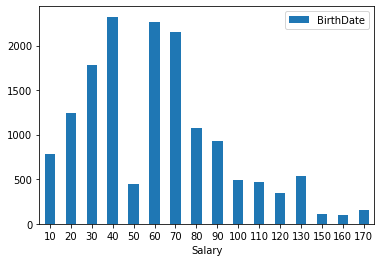

In [52]:
df_bikesales.groupby(['Salary']).count()[['BirthDate']].plot.bar(rot=0)

## 2)  Age seems like an attribute that would affect this model.  List the highest, lowest, median, mean, and quartiles of the Customers's age.

In [53]:
df_bikesales['Age'].describe()

count    15205.000000
mean        48.488918
std         10.351013
min         32.000000
25%         40.000000
50%         46.000000
75%         55.000000
max         91.000000
Name: Age, dtype: float64

## 3)  Create a pie chart of the count of customers by Education.

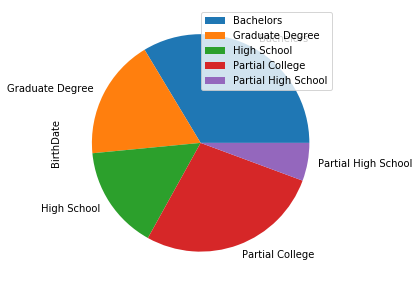

In [54]:
df_education = df_bikesales.groupby(['Education']).count()[['BirthDate']]
df_education.head()
df_education.plot.pie(y='BirthDate', figsize=(5, 5))
# plot = df.plot.pie(y='mass', figsize=(5, 5))

## Where's the Bike Type?

### You notice that there is no Bike Type column.  Fortunately, the ModelName has the bike type as the first word in the name followed by a dash.  You decide to extract this and put it in a new column named BikeType, i.e. Touring, Road, Mountain.  This is what the model will be trained to predict.

In [55]:
df_bikesales["BikeType"] = df_bikesales["ModelName"].str.split("-", n = 1, expand = True).loc[:,0]

### Now do a count by BikeType to see how it breaks out.

In [56]:
df_typecount = df_bikesales.groupby(['BikeType']).count()[['BirthDate']]
df_typecount.rename(columns={'BirthDate': 'Count'}, inplace=True)
df_typecount

,Count
BikeType,
Mountain,4970
Road,8068
Touring,2167


## Feature Engineering:

### Looking at the data, some columns seem like they would be more useful, if they were transformed.  

### > For example, the number of children at home seems less important than if there are any children at home.  
### > Individual ages seems less relavant than age ranges like under 18 and over 60.  
### > YearlyIncome is more useful in ranges like low, medium, high.  


# Add columns that transform the data as follows. 

### - Convert ChildrentAtHome from continuous value to boolean
### - Convert Age to Age Bands making it a categorical value
### - Convert YearlyIncome into Income Bands making it a categorical value

### In the cell below, convert Children at home to 'yes' if it is greater than zero, otherwise set it to 'no'.

In [57]:
import numpy as np

df_bikesales['ChildrenAtHome'] = np.where(df_bikesales['NumberChildrenAtHome']>0, 'yes', 'no')
df_bikesales['ChildrenAtHome'].head()

0     no
1    yes
2     no
3     no
4     no
Name: ChildrenAtHome, dtype: object

### In the cell below, create a column AgeBand that assigns a string value based on value as follows:

- '0-18'
- '19-29'
- '30-39'
- '40-49'
- '50-59'
- '60+'

In [58]:
df_bikesales['AgeBand'] =  pd.cut(df_bikesales['Age'], [0, 18, 29, 39, 49, 59, 200], labels=['0-18', '19-29', '30-39', '40-49', '50-59', '60+'])

#### In the cell below, create a column IncomeBand that assigns a string value based on value as follows:

- '0-49k'
- '50-99k'
- '100-149k'
- '150-199k'
- '200-299k'
- '300+'

In [59]:
df_bikesales['IncomeBand'] =  pd.cut(df_bikesales['YearlyIncome'], [0, 49000, 99000, 149000, 199000, 299999, 5000000], labels=['0-49k', '50-99k', '100-149k', '150-199k', '200-299k', '300+'])

## All of our input features are really categories and need to be converted to categorical variables before they can be used in model training.  Categorical variables are number that represent a category.  Create a new column that is the source column name suffixed with Cat for the columns below:

Example:  BikeTypeCat will hold the categorical value of BikeType.

- BikeType
- AgeBand
- IncomeBand
- MaritalStatus
- Gender
- ChildrenAtHome
- CountryRegionCode
- HouseOwnerFlag
- Education
- Occupation
- CommuteDistance

## Convert categorical variables...

In [1]:
#Define categorical columns
CatCol = ['BikeType', 'AgeBand', 'IncomeBand', 'MaritalStatus', 'Gender', 'ChildrenAtHome','CountryRegionCode', 
          'HouseOwnerFlag', 'Education', 'Occupation', 'CommuteDistance']

#Define suffix
Cat = 'Cat'

In [61]:
#change object column names to categories and append suffix to column name
for col in CatCol:
    df_bikesales[col + Cat] = df_bikesales[col].astype('category')

#Create new column name list with appended suffix to column names
CatColSuf = [s + Cat for s in CatCol] 

#create category codes
for col in CatColSuf:
    df_bikesales[col] = df_bikesales[col].cat.codes

In [62]:
from pandasql import *

pysqldf = lambda q: sqldf(q, globals())

# Create BikeType dictionary to translate our predicted values...

### A problem with using categorical values is that you can't tell what the predicted result is.  Run the code below to create a Python dictionary to be used later to translated predicted bike type values.

Note:  Pandas has a module called pandassql that let's us use SQL with dataframes.  You may find some queries easier using SQL.

In [63]:
from pandasql import *

pysqldf = lambda q: sqldf(q, globals())

df_types = sqldf('select distinct BikeType, BikeTypeCat from df_bikesales order by BikeTypeCat')
df_types

,BikeType,BikeTypeCat
0,Mountain,0
1,Road,1
2,Touring,2


In [64]:
typedict = dict(zip(df_types.BikeTypeCat, df_types.BikeType))
typedict

{0: 'Mountain', 1: 'Road', 2: 'Touring'}

# Extract the features to a new dataframe...

In [65]:
df_features = df_bikesales[CatColSuf]

In [66]:
df_features.head()

,BikeTypeCat,AgeBandCat,IncomeBandCat,MaritalStatusCat,GenderCat,ChildrenAtHomeCat,CountryRegionCodeCat,HouseOwnerFlagCat,EducationCat,OccupationCat,CommuteDistanceCat
0,1,5,1,1,1,0,1,1,0,1,2
1,0,3,0,1,0,1,3,0,2,2,0
2,0,5,0,1,0,0,5,1,2,3,2
3,1,5,1,0,1,0,5,1,1,1,1
4,0,3,1,1,0,0,0,0,0,3,4


In [21]:
df_features.dtypes

BikeTypeCat             int8
AgeBandCat              int8
IncomeBandCat           int8
MaritalStatusCat        int8
GenderCat               int8
ChildrenAtHomeCat       int8
CountryRegionCodeCat    int8
HouseOwnerFlagCat       int8
EducationCat            int8
OccupationCat           int8
CommuteDistanceCat      int8
dtype: object

# The scikit-learn models only support numpy arrays, not dataframes so we need to convert our dataframe to a numpy array.  Fortunately, the pandas dataframe values method will do this for us. 

In [22]:
# Exampls of using the values method...

df_features.values

array([[1, 5, 1, ..., 0, 1, 2],
       [0, 3, 0, ..., 2, 2, 0],
       [0, 5, 0, ..., 2, 3, 2],
       ...,
       [2, 3, 2, ..., 4, 1, 2],
       [1, 2, 0, ..., 3, 2, 3],
       [1, 4, 0, ..., 4, 0, 4]], dtype=int8)

# Split the data...

In [23]:
from sklearn.model_selection import train_test_split

X_train_all , X_test_all = train_test_split(df_features.values,test_size=0.2)       #test_size=0.5(whole_data)

### Extract the response variable...

In [24]:
# Column 0 has the value we want to predict, i.e. the model a customer will purchase.
X_train_all[:,0]

array([2, 0, 1, ..., 1, 0, 1], dtype=int8)

In [25]:
y_train = X_train_all[:,0]
y_train

array([2, 0, 1, ..., 1, 0, 1], dtype=int8)

In [26]:
y_test = X_test_all[:,0]
y_test

array([2, 1, 1, ..., 2, 0, 2], dtype=int8)

In [27]:
# Check the BikeType...
X_test_all[:,0]

array([2, 1, 1, ..., 2, 0, 2], dtype=int8)

In [28]:
X_train_all.shape

(12164, 11)

### Extract the feature columns...

In [29]:
X_train = X_train_all[:,1:11]
X_train.shape

(12164, 10)

In [30]:
X_test = X_test_all[:,1:11]
X_test

array([[3, 0, 0, ..., 0, 4, 0],
       [4, 1, 0, ..., 3, 4, 4],
       [3, 2, 0, ..., 4, 3, 2],
       ...,
       [4, 1, 0, ..., 1, 3, 0],
       [3, 0, 0, ..., 0, 4, 0],
       [4, 1, 1, ..., 2, 3, 1]], dtype=int8)

# Train the model...

In [ ]:
#Importing Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
print('Libraries Imported')

In [32]:
# Confirm we have a numpy array...
type(X_train)

numpy.ndarray

In [33]:
# Check the input features array...
X_train

array([[4, 0, 1, ..., 4, 0, 4],
       [3, 1, 1, ..., 0, 3, 0],
       [3, 1, 0, ..., 0, 3, 1],
       ...,
       [3, 2, 1, ..., 1, 1, 0],
       [5, 2, 0, ..., 3, 3, 2],
       [2, 0, 0, ..., 0, 4, 1]], dtype=int8)

In [34]:
y_train

array([2, 0, 1, ..., 1, 0, 1], dtype=int8)

In [35]:
# for predicting bike type...

classifier = RandomForestClassifier(n_estimators = 800, criterion = 'entropy', random_state = 42, max_depth=12)
classifier.fit(X_train, y_train)
print('Done')

Done


## About model performance...

### Our goal is to learn how touse Azure Machine Learning service and the performance of our model does not matter towards that end.  Don't worry if the model is not predicting very well.  Performance can be improved by more experimentation.  Also, Azure Machine Learning service AutoML, which we will see later, can tune the mode for you.

## As a sanity check, we will predict on the training data and so the confusion matrix.

In [36]:
# Sanity check, can we at least get good predictions with the training data?

# Predict using the training data...
y_predtrain = classifier.predict(X_train)
y_predtrain

array([2, 1, 1, ..., 1, 0, 1], dtype=int8)

In [37]:
# Prediction of Bike Type using the training data...

#Reverse factorize 
y_testr = np.vectorize(typedict.get)(y_train)
y_predr = np.vectorize(typedict.get)(y_predtrain)

# Making the Confusion Matrix
print(pd.crosstab(y_testr, y_predr, rownames=['Actual Model'], colnames=['Predicted Model']))

Predicted Model  Mountain  Road  Touring
Actual Model                            
Mountain             1634  2320       33
Road                  633  5772       24
Touring               477  1086      185


In [38]:
# Do the test data set predictions...

# Predict using the test data...
y_predtest = classifier.predict(X_test)
y_predtest

array([1, 1, 1, ..., 0, 1, 1], dtype=int8)

In [39]:
y_predtest.shape
y_test.shape

(3041,)

In [40]:
# Do the test data set predictions...

#Reverse factorize 
y_testr = np.vectorize(typedict.get)(y_test)
y_predr = np.vectorize(typedict.get)(y_predtest)

# Making the Confusion Matrix

print(pd.crosstab(y_testr, y_predr, rownames=['Actual Type'], colnames=['Predicted Type']))

Predicted Type  Mountain  Road  Touring
Actual Type                            
Mountain             228   723       32
Road                 298  1314       27
Touring              144   265       10


In [41]:
print(y_predtest)
print(y_predtrain)

[1 1 1 ... 0 1 1]
[2 1 1 ... 1 0 1]


# Save the feature set data for future labs.

In [68]:
import pandas as pd

df_features.to_csv(os.path.join(dd, 'BikeModelFeatures.csv'), sep=',', index=False)

In [43]:
import pickle

f = open("typedict.pkl","wb")
pickle.dump(typedict,f)
f.close()

## Save the trained model for later...

In [44]:
joblib.dump(classifier, 'biketypeclassifier.pkl') 

['biketypeclassifier.pkl']